In [3]:
import sys
import os
module_dir = os.path.abspath("/lustrehome/federicacuna/TB_Sept_2023_ml/Code/Pytorch_gnn/")
sys.path.append(module_dir)

In [4]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv,GATConv
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
import MyData as data
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression


from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import GNN_model

In [31]:
sel_alg=1
num_ly=6
lr=0.0001
folder_pkl='optimized_balanced_norm'
n_epochs=200
batch_size=4032
num_toreduce=64

In [32]:
if "." in str(lr):
    lr_name = str(lr).replace(".", "_")
    print(lr_name)
else:
    lr_name = str(lr)
    print(lr_name)

0_0001


In [33]:
%%time
data_handler=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed')
fnamex='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewx'
fnamey='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewy'
# data_trk=data_handler.get_more_file(0,250,fnamex)+data_handler.get_more_file(0,250,fnamey)
# data_val=data_handler.get_more_file(600,640,fnamex)+data_handler.get_more_file(600,640,fnamey)
data_trk=data_handler.get_more_file(0,5,fnamex)+data_handler.get_more_file(0,5,fnamey)
data_val=data_handler.get_more_file(600,601,fnamex)+data_handler.get_more_file(600,601,fnamey)

taking a list of file from  0  to  5
taking a list of file from  0  to  5
taking a list of file from  600  to  601
taking a list of file from  600  to  601
CPU times: user 14.5 s, sys: 295 ms, total: 14.8 s
Wall time: 14.8 s


In [34]:
data_handler2=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed')
fnameHNx='pi-_10GeV_4ly_3e-4ly_normalized_viewx'
fnameHNy='pi-_10GeV_4ly_3e-4ly_normalized_viewy'
# dataHN=data_handler2.get_more_file(0,250,fnameHNx)+data_handler2.get_more_file(0,250,fnameHNy)
# dataHN_val=data_handler2.get_more_file(600,640,fnameHNx)+data_handler2.get_more_file(600,640,fnameHNy)
dataHN=data_handler2.get_more_file(0,3,fnameHNx)+data_handler2.get_more_file(0,3,fnameHNy)
dataHN_val=data_handler2.get_more_file(600,601,fnameHNx)+data_handler2.get_more_file(600,601,fnameHNy)

taking a list of file from  0  to  3
taking a list of file from  0  to  3
taking a list of file from  600  to  601
taking a list of file from  600  to  601


In [35]:
data_test=data_handler.get_more_file(800,801,fnamex)+data_handler.get_more_file(800,801,fnamey)
data_test_HN=data_handler2.get_more_file(800,801,fnameHNx)+data_handler.get_more_file(800,801,fnameHNy)
test_dataset=data_test+data_test_HN

taking a list of file from  800  to  801
taking a list of file from  800  to  801
taking a list of file from  800  to  801
taking a list of file from  800  to  801


In [36]:
train_dataset=(dataHN[:1800000]+data_trk[:2200000])
print(len(train_dataset))

114152


0.5178873329382148
0.4821126670617853


<BarContainer object of 2 artists>

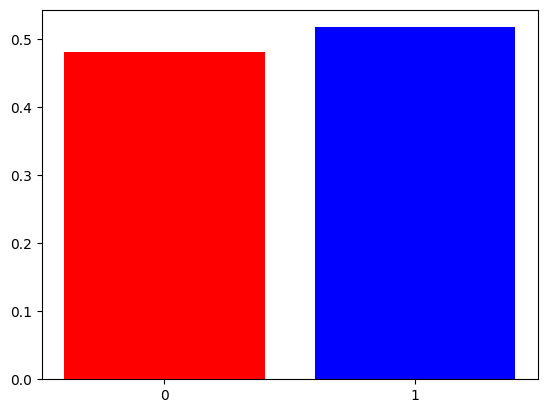

In [37]:
y_values = [item for data in train_dataset for item in data.y.tolist()]
total_nodes = sum([len(data.y.tolist()) for data in train_dataset])
count_1 = y_values.count(1)/total_nodes
count_0 = y_values.count(0)/total_nodes
print(count_1)
print(count_0)
plt.bar(['0', '1'], [count_0, count_1], color=['red', 'blue'])

In [38]:
val_dataset=dataHN_val[:360000]+data_val[:440000]

0.48237896452508855
0.5176210354749115


<BarContainer object of 2 artists>

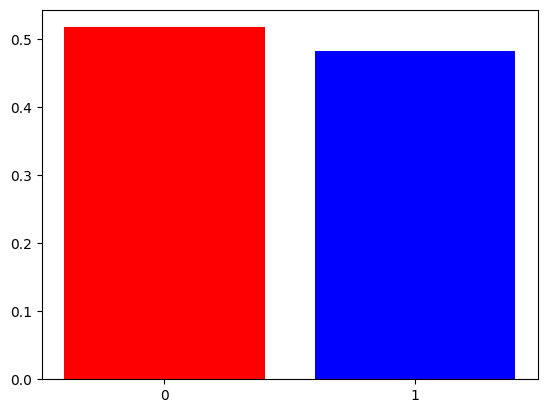

In [39]:
y_values = [item for data in val_dataset for item in data.y.tolist()]
total_nodes = sum([len(data.y.tolist()) for data in val_dataset])
count_1 = y_values.count(1)/total_nodes
count_0 = y_values.count(0)/total_nodes
print(count_1)
print(count_0)
plt.bar(['0', '1'], [count_0, count_1], color=['red', 'blue'])

In [40]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    15.3 GB
CPU times: user 70 µs, sys: 1.38 ms, total: 1.45 ms
Wall time: 489 µs


In [41]:
%%time
NUM_FEATURES = 5#train_dataset[0].x.shape[1]
print(NUM_FEATURES)
NUM_CLASSES =1
n_ly=4
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT']

5
CPU times: user 0 ns, sys: 929 µs, total: 929 µs
Wall time: 298 µs


In [42]:
hidden_size = num_toreduce*num_ly

In [43]:
outname=f'Balanced_norm_DATA_best_model{model_list[sel_alg]}_lytrk{n_ly}_lr{lr_name}_epochs_{n_epochs}_lentrain{len(train_dataset)}_numly{num_ly}.pkl'

In [44]:
print(outname)

Balanced_norm_DATA_best_modelSageConv2_lytrk4_lr0_0001_epochs_200_lentrain114152_numly6.pkl


In [45]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==1:
    model = GNN_model.SageConv2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)

In [46]:
print(model)

SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 384, aggr=mean)
    (1): SAGEConv(384, 320, aggr=mean)
    (2): SAGEConv(320, 256, aggr=mean)
    (3): SAGEConv(256, 192, aggr=mean)
    (4): SAGEConv(192, 128, aggr=mean)
    (5): SAGEConv(128, 64, aggr=mean)
    (6): SAGEConv(64, 1, aggr=mean)
  )
)


In [47]:
%%time
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
####criterion = torch.nn.CrossEntropyLoss()
criterion=torch.nn.functional.binary_cross_entropy#for sageconv

def train_model(train_data):
    model.to(device)
    model.train()
    for data in train_data:
        data.to(device)
        out = model(data) # Perform a single forward pass.
        labels=data.y.float().to(device)
        loss = criterion(out.squeeze(1).float(), labels)  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return model.to(device)

threshold=0.8
def evaluate_model(model,test_data):
    model.eval()
    correct = 0
    total_samples = 0
    model_outputs = []
    targets = []
    pred_class=[]

    for data in test_data:
        data.to(device)
        model_output = model(data)
        model_output.to(device)
        predicted_class = torch.where(model_output > threshold, 1, 0)
        
        correct += int((predicted_class == data.y.float()).sum())
        total_samples += len(data.y)

          # store these to get the loss
        model_outputs.extend(model_output.tolist())
        targets.extend(data.y.float().tolist())
        pred_class.extend(predicted_class.tolist())

    
    loss = criterion(torch.tensor(model_outputs).squeeze(1), torch.tensor(targets).float())
    accuracy = accuracy_score(targets, pred_class)
    precision = precision_score(targets, pred_class)
    recall = recall_score(targets, pred_class)
    
    return accuracy, loss, recall, precision 


CPU times: user 2.21 ms, sys: 5.09 ms, total: 7.31 ms
Wall time: 2.65 ms


In [48]:
## %%time
train_loader = DataLoader(train_dataset, batch_size=4032,shuffle=True,pin_memory=True,num_workers=16,drop_last=True) 
val_loader=DataLoader(val_dataset, batch_size=128,shuffle=True,pin_memory=True,num_workers=16,drop_last=True) 
test_loader=DataLoader(test_dataset, batch_size=64,shuffle=True,drop_last=True)

In [49]:
%%time
train_accuracies = []
validation_accuracies = []
validation_losses = []
train_losses = []

val_recall=[]
val_precision=[]
train_recall=[]
train_precision=[]
times = []

for epoch in range(1, n_epochs):
    start = time.time()
    print(epoch)
    model = train_model(train_loader)
    print(next(model.parameters()).is_cuda)
    
    train_acc, train_loss, train_rec, train_prec = evaluate_model(model,train_loader)
    train_losses.append(train_loss)
                   
    val_acc, val_loss, val_rec, val_prec = evaluate_model(model,val_loader)
    validation_losses.append(val_loss)

    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    
    train_precision.append(train_prec)
    train_recall.append(train_rec)
    
    val_precision.append(val_prec)
    val_recall.append(val_rec)

    # save the model if it is the better than any previous ones
    if val_loss.item() <= min(validation_losses).item():
        # torch.save(model, f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/{folder_pkl}/{outname}')
        print(f'Epoch_stop: {epoch}')
          
    #torch.save(model, "best_model.pkl")
    if epoch % 1 == 0:
        print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, time :{time.time() - start}')
    times.append(time.time() - start)
  

1
True


/home/federicacuna/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/federicacuna/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch_stop: 1
Epoch: 1, Train Acc: 0.4821, Train Loss: 0.6485, Val Acc: 0.5176, Val Loss: 0.6512, time :16.99379277229309
2
True
Epoch_stop: 2
Epoch: 2, Train Acc: 0.5825, Train Loss: 0.5646, Val Acc: 0.6040, Val Loss: 0.5732, time :19.966647624969482
3
True
Epoch_stop: 3
Epoch: 3, Train Acc: 0.5839, Train Loss: 0.5491, Val Acc: 0.6050, Val Loss: 0.5554, time :19.32865262031555
4
True
Epoch_stop: 4
Epoch: 4, Train Acc: 0.5960, Train Loss: 0.5361, Val Acc: 0.6150, Val Loss: 0.5434, time :18.833341360092163
5
True
Epoch_stop: 5
Epoch: 5, Train Acc: 0.5921, Train Loss: 0.5236, Val Acc: 0.6123, Val Loss: 0.5301, time :19.901061058044434
6
True
Epoch_stop: 6
Epoch: 6, Train Acc: 0.6035, Train Loss: 0.5125, Val Acc: 0.6212, Val Loss: 0.5228, time :19.128965854644775
7
True
Epoch_stop: 7
Epoch: 7, Train Acc: 0.5891, Train Loss: 0.5054, Val Acc: 0.6094, Val Loss: 0.5133, time :21.38796377182007
8
True
Epoch_stop: 8
Epoch: 8, Train Acc: 0.5938, Train Loss: 0.4983, Val Acc: 0.6128, Val Loss: 0.5

In [50]:
best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuracies[best_epoch]
recall_at_best_epoch=val_recall[best_epoch]
precision_at_best_epoch=val_precision[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch:.4f} and a loss of {best_validation_loss:.4f}")
print(f"The validation recall is {recall_at_best_epoch:.4f} and the precision is {precision_at_best_epoch:.4f}")

The best result was achieved after 96 epochs with a validation accuracy of 0.9221 and a loss of 0.1651
The validation recall is 0.8704 and the precision is 0.9647


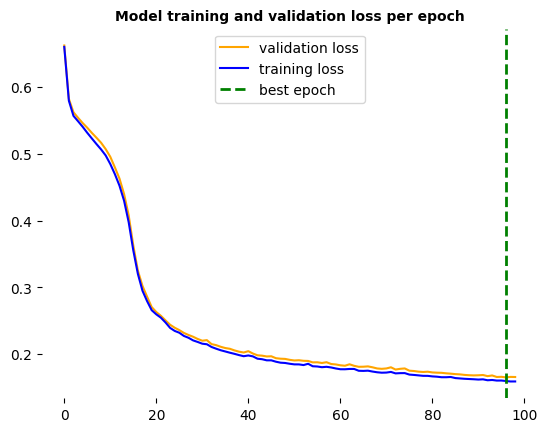

In [29]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses,color='orange',label='validation loss')
plt.plot(train_losses,color='blue',label='training loss')

plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed',label='best epoch')
#plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])
plt.legend()


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=10, fontweight='bold')
#plt.ylim(0.05,0.2)
# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_loss_{model_list[sel_alg]}_lr_{lr_name}_400epochs.png')
plt.show()

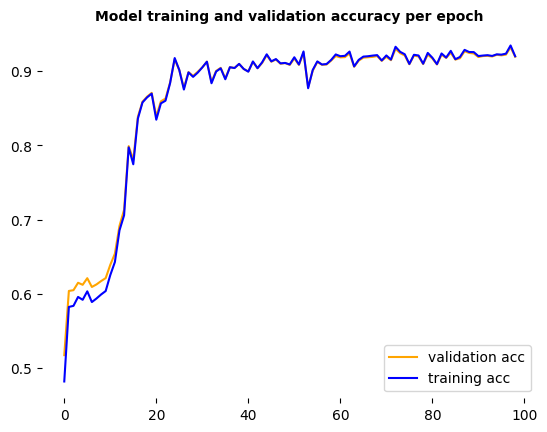

In [51]:
fig, ax = plt.subplots()
#fig.set_size_inches(30.5, 15.5)

plt.plot(validation_accuracies,color='orange',label='validation acc')
plt.plot(train_accuracies,color='blue',label='training acc')

plt.legend()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation accuracy per epoch", fontsize=10, fontweight='bold')
# plt.ylim(0.9,1)
# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/{folder_pkl}/model_acc_{model_list[sel_alg]}_lr_{lr_name}_400epochs.png')
plt.show()

In [ ]:
best_model = torch.load( f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/{folder_pkl}/{outname}')
best_model.to(device) 

correct = 0
total_samples = 0
pred_test_cl=[]
targets=[]
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)  
        model_output = best_model(data)
        predicted_class =  torch.where(model_output > 0.8, 1, 0)
        pred_test_cl.extend(predicted_class.tolist())
        correct += int((predicted_class == data.y).sum())
        targets.extend(data.y.tolist())
        total_samples += data.y.size(0)

print('accuracy ',accuracy_score(targets,pred_test_cl),' recall ', recall_score(targets,pred_test_cl),' precision ',precision_score(targets,pred_test_cl))
